In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline
#
import tensorflow as tf
import keras
from keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

In [ ]:
from PIL import Image

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset

Dataset URL: https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset
License(s): unknown
 80% 97.0M/121M [00:01<00:00, 104MB/s]
100% 121M/121M [00:01<00:00, 105MB/s] 


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/face-expression-recognition-dataset.zip')
zip_ref.extractall('/content/kaggle/input/face-expression-recognition-dataset')
zip_ref.close()

# Analyzing existing dataset

In [ ]:
TRAIN_DIR = '/content/kaggle/input/face-expression-recognition-dataset/images/train/'
TEST_DIR = '/content/kaggle/input/face-expression-recognition-dataset/images/validation/'

In [ ]:
def load_dataset(directory):
    image_paths = []
    labels = []

    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)

        print(label, "Completed")

    return image_paths, labels

In [ ]:
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
train = train.sample(frac=1).reset_index(drop=True)
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)


surprise Completed
disgust Completed
happy Completed
fear Completed
neutral Completed
sad Completed
angry Completed
surprise Completed
disgust Completed
happy Completed
fear Completed
neutral Completed
sad Completed
angry Completed


<Axes: xlabel='label', ylabel='count'>

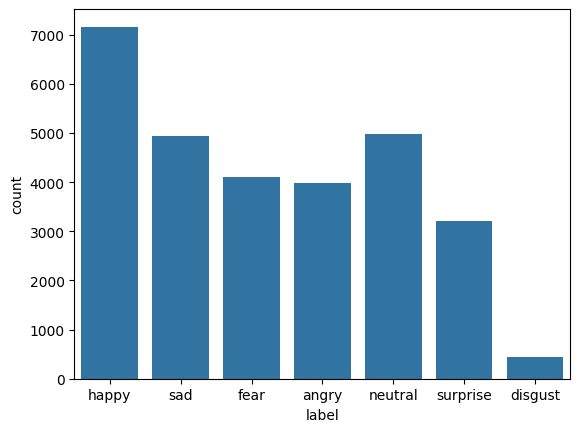

In [ ]:
sns.countplot(train, x = 'label' )

The disparity in the training dataset is extreme!

<Axes: xlabel='label', ylabel='count'>

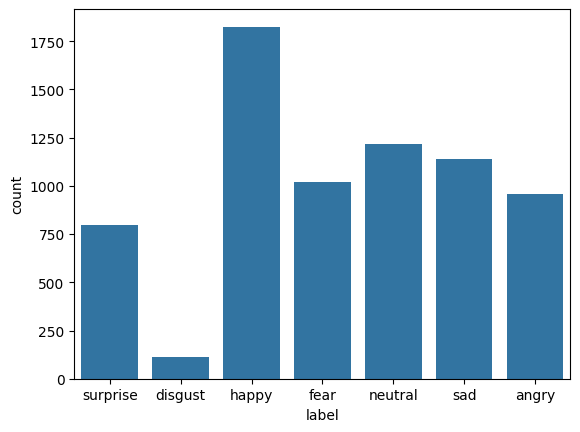

In [ ]:
sns.countplot(test, x='label')

The disparity in the test dataset is extreme as well!

# Data Augmentation - easy way to normalize datasets

In [ ]:
def flip_images(directory): #flips images
  for filename in os.listdir(directory):
    if filename.endswith(('.jpg', '.jpeg','.png')):
      imgpath = os.path.join(directory,filename)
      with Image.open(imgpath) as img:
        flipped_img = img.transpose(Image.FLIP_LEFT_RIGHT)
        flipped_file = f'flipped_{filename}'
        flipped_path = os.path.join(directory,flipped_file)
        flipped_img.save(flipped_path)

def rotate_img(directory): #rotates images to a random angle between 0 and 360
  for filename in os.listdir(directory):
    if filename.endswith(('.jpg','.jpeg','.png')):
      imgpath = os.path.join(directory,filename)
      with Image.open(imgpath) as img:
        angle = random.randint(1,359)
        rotated_img = img.rotate(angle,expand=True)
        rotated_file = f'rotated_{filename}'
        rotated_path = os.path.join(directory,rotated_file)
        rotated_img.save(rotated_path)

def scale_img(directory): #scales images to anywhere between 60% to 260%
  for filename in os.listdir(directory):
    if filename.endswith(('.jpg','.jpeg','.png')):
      imgpath = os.path.join(directory,filename)
      with Image.open(imgpath) as img:
        scale_factor = round(2*(0.3+random.random()),3)
        new_width = int(img.width*scale_factor) ; new_height = int(img.height*scale_factor)
        scaled_img = img.resize((new_width,new_height))
        scaled_file = f'scaled_{filename}'
        scaled_path = os.path.join(directory,scaled_file)
        scaled_img.save(scaled_path)


In [ ]:
#Augmenting the training images in 'disgust'


directory = '/content/kaggle/input/face-expression-recognition-dataset/images/train/disgust'
flip_images(directory)
rotate_img(directory)
scale_img(directory)

In [ ]:
#Augmenting the test images in 'disgust'

directory = '/content/kaggle/input/face-expression-recognition-dataset/images/validation/disgust'
flip_images(directory)
rotate_img(directory)
scale_img(directory)

In [ ]:
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
train = train.sample(frac=1).reset_index(drop=True)
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)

surprise Completed
disgust Completed
happy Completed
fear Completed
neutral Completed
sad Completed
angry Completed
surprise Completed
disgust Completed
happy Completed
fear Completed
neutral Completed
sad Completed
angry Completed


Now that we've applied our augmentation and defined train and test again, let's look at the datasets.

<Axes: xlabel='label', ylabel='count'>

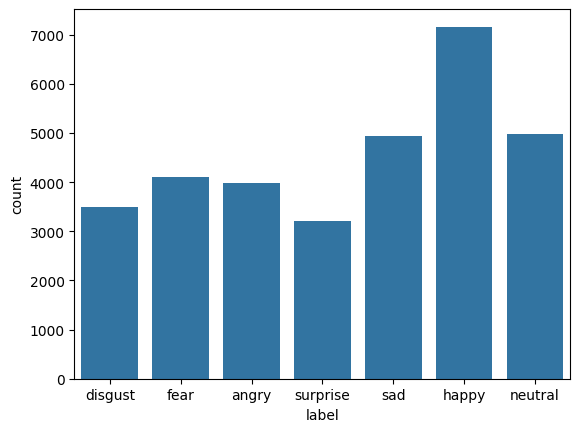

In [ ]:
sns.countplot(train,x='label')

More balanced now! Let's look at the test data:

<Axes: xlabel='label', ylabel='count'>

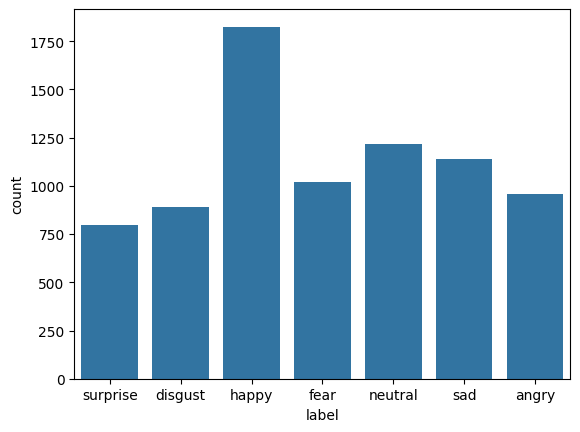

In [ ]:
sns.countplot(test,x='label')

Let's add some more normalization by reducing the number of images in the happy dataset - we'll achieve this by calculating the average number of images in the other sets, and reducing the happy dataset to that number

In [ ]:
def num_files(directory):
  images = [f for f in os.listdir(directory) if f.endswith(('.jpg','.jpeg','.png'))]
  return len(images)

def avg_files(directories):
  total = 0
  dir_count = 0
  for directory in directories:

    if directory.split('/')[-1] == 'happy': continue
    total += num_files(directory)
    dir_count+=1
  return int(total/dir_count)

def delete_random(directory, count):
  images = [f for f in os.listdir(directory) if f.endswith(('.jpg','.jpeg','.png'))]
  if len(images) < count: return 'Not enough images'
  deleted_images = random.sample(images, count)
  for image in deleted_images:
    image_path = os.path.join(directory,image)
    os.remove(image_path)



In [ ]:
dir = '/content/kaggle/input/face-expression-recognition-dataset/images/train'
directories = [os.path.join(dir, i) for i in os.listdir(dir)]
av_count = avg_files(directories)
delete_count = num_files(os.path.join(dir,'happy')) - av_count

delete_random(os.path.join(dir,'happy'),delete_count)



In [ ]:
dir = '/content/kaggle/input/face-expression-recognition-dataset/images/validation'
directories = [os.path.join(dir, i) for i in os.listdir(dir)]
av_count = avg_files(directories)
delete_count = num_files(os.path.join(dir,'happy')) - av_count

delete_random(os.path.join(dir,'happy'),delete_count)

In [ ]:
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
train = train.sample(frac=1).reset_index(drop=True)
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)

surprise Completed
disgust Completed
happy Completed
fear Completed
neutral Completed
sad Completed
angry Completed
surprise Completed
disgust Completed
happy Completed
fear Completed
neutral Completed
sad Completed
angry Completed


<Axes: xlabel='label', ylabel='count'>

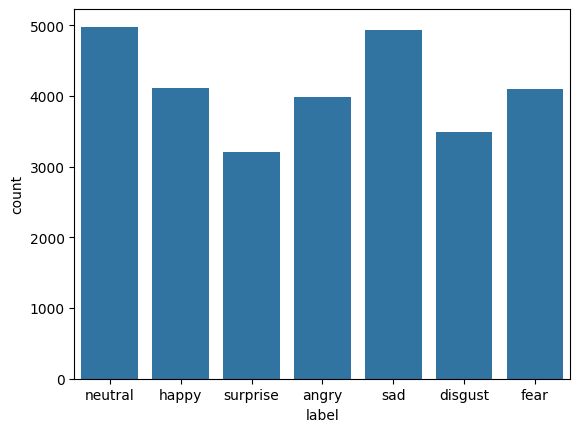

In [ ]:
sns.countplot(train,x='label')

<Axes: xlabel='label', ylabel='count'>

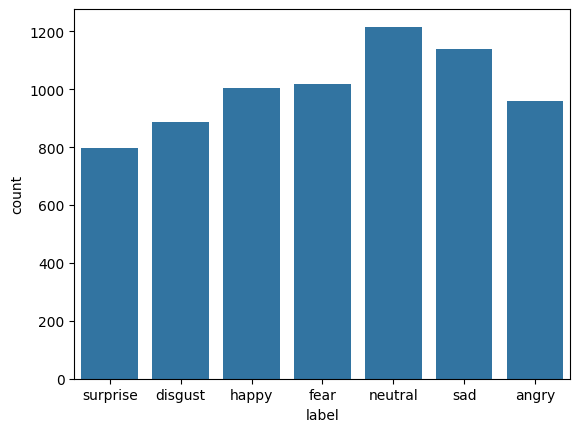

In [ ]:
sns.countplot(test,x='label')

Now the image sets are usable for training!  

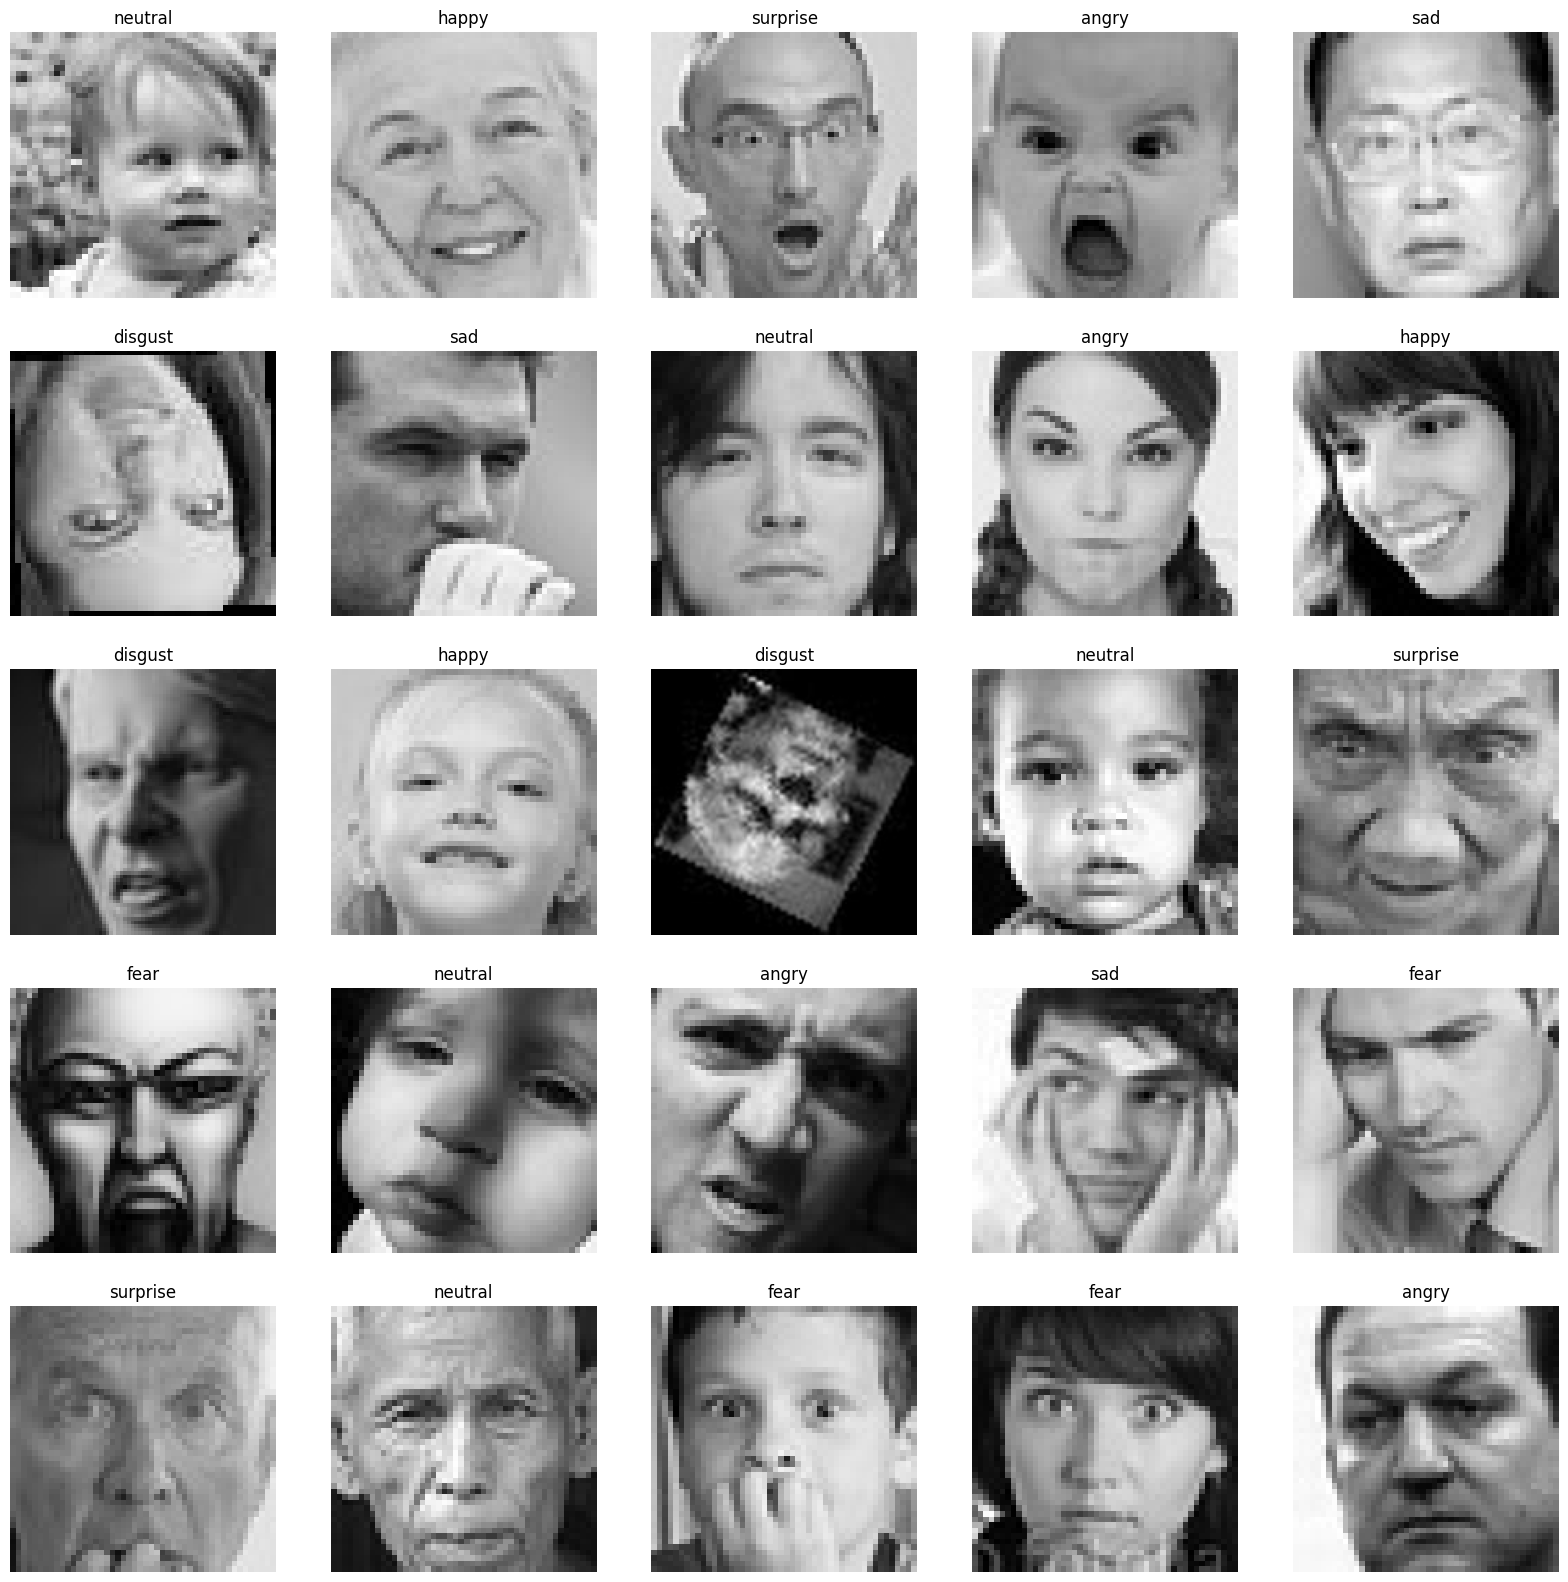

In [ ]:
# to display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

In [ ]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = Image.open(image).convert('L')
        img = img.resize((112,112))
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 112, 112, 1)
    return features

In [ ]:
train_features = extract_features(train['image'])

  0%|          | 0/28827 [00:00<?, ?it/s]

In [ ]:
test_features = extract_features(test['image'])

  0%|          | 0/7021 [00:00<?, ?it/s]

In [ ]:
## normalize the image
x_train = train_features/255.0
x_test = test_features/255.0

In [ ]:
# convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [ ]:
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [ ]:
# config
input_shape = (112, 112, 1)
output_class = 7

In [ ]:
from keras.layers import BatchNormalization, Activation, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

In [ ]:
model = Sequential()

model.add(Conv2D(64, kernel_size=(3,3), padding='same', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(192, kernel_size=(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(576, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(576, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(384))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(384))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


model.add(Dense(output_class, activation='softmax'))
optim = Adam(learning_rate=0.005)

model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 112, 112, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 56, 56, 192)         │         307,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 56, 56, 192)         │             768 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 56, 56, 192)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 28, 28, 192)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 28, 28, 192)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 576)         │         995,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 28, 28, 576)         │           2,304 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 28, 28, 576)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 14, 14, 576)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 14, 14, 576)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 14, 14, 576)         │       2,986,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 14, 14, 576)         │           2,304 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 14, 14, 576)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 7, 7, 576)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 15,288,135 (58.32 MB)

 Trainable params: 15,283,783 (58.30 MB)

 Non-trainable params: 4,352 (17.00 KB)

In [ ]:
print(x_train.shape)
print(y_train.shape)


(28827, 112, 112, 1)
(28827, 7)


In [ ]:
print(np.isnan(x_train).any())
print(np.isinf(x_train).any())
print(np.isnan(y_train).any())
print(np.isinf(y_train).any())


False
False
False
False


In [ ]:
checkpoint = ModelCheckpoint("model.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit(x=x_train, y=y_train, batch_size=72, epochs=25, validation_split = 0.25, callbacks=callbacks_list)

Epoch 1/25
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.2620 - loss: 1.9149
Epoch 1: val_accuracy improved from -inf to 0.18593, saving model to model.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 118s 302ms/step - accuracy: 0.2622 - loss: 1.9144 - val_accuracy: 0.1859 - val_loss: 1.9123
Epoch 2/25
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.4123 - loss: 1.5078
Epoch 2: val_accuracy improved from 0.18593 to 0.34550, saving model to model.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 106s 258ms/step - accuracy: 0.4124 - loss: 1.5076 - val_accuracy: 0.3455 - val_loss: 1.7839
Epoch 3/25
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.4988 - loss: 1.2978
Epoch 3: val_accuracy improved from 0.34550 to 0.44901, saving model to model.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 82s 259ms/step - accuracy: 0.4988 - loss: 1.2977 - val_accuracy: 0.4490 - val_loss: 1.4122
Epoch 4/25
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.5586 - loss: 1.1569
Epoch 4: val_accuracy improved from 0

In [ ]:
history1 = model.fit(x=x_train, y=y_train, batch_size=144, epochs=10, validation_split = 0.2, callbacks=callbacks_list)

Epoch 1/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.9512 - loss: 0.1927
Epoch 1: val_accuracy improved from 0.61329 to 0.62296, saving model to model.keras
161/161 ━━━━━━━━━━━━━━━━━━━━ 126s 584ms/step - accuracy: 0.9512 - loss: 0.1927 - val_accuracy: 0.6230 - val_loss: 1.4027
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.9723 - loss: 0.0905
Epoch 2: val_accuracy improved from 0.62296 to 0.62539, saving model to model.keras
161/161 ━━━━━━━━━━━━━━━━━━━━ 105s 554ms/step - accuracy: 0.9723 - loss: 0.0905 - val_accuracy: 0.6254 - val_loss: 1.6203
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.9781 - loss: 0.0678
Epoch 3: val_accuracy improved from 0.62539 to 0.62678, saving model to model.keras
161/161 ━━━━━━━━━━━━━━━━━━━━ 131s 485ms/step - accuracy: 0.9781 - loss: 0.0678 - val_accuracy: 0.6268 - val_loss: 1.8094
Epoch 4/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.9834 - loss: 0.0475
Epoch 4: val_accuracy did not imp

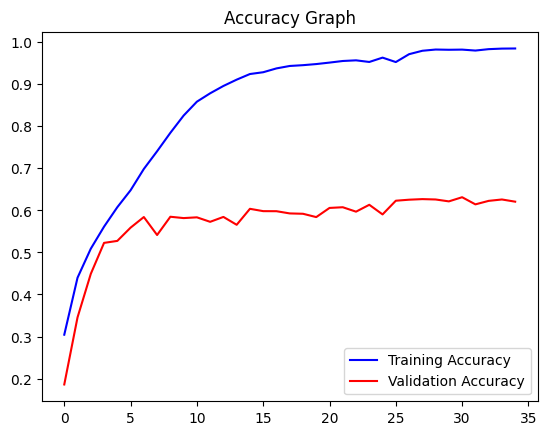

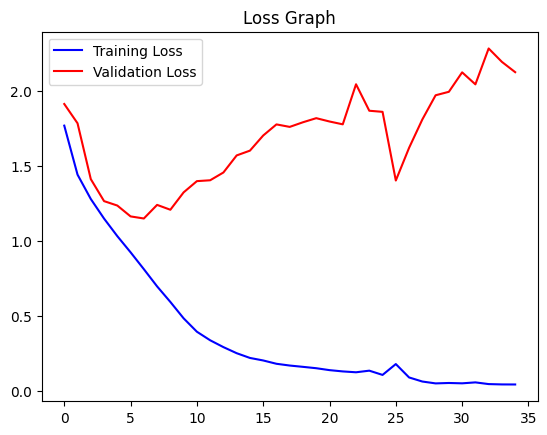

In [ ]:
acc = history.history['accuracy'] + history1.history['accuracy']
val_acc = history.history['val_accuracy'] + history1.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss'] + history1.history['loss']
val_loss = history.history['val_loss'] + history1.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

In [ ]:
(loss,acc) = model.evaluate(x_test, y_test)
print (round(acc*100,3), "%")

220/220 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.6947 - loss: 1.9039
61.473 %


In [ ]:
def prep(image):
  img = Image.open(image).convert('L')
  img = img.resize((112,112))
  plt.imshow(img)
  img = np.array(img)
  img = img/255.0
  return img.reshape(1,112,112,1)

def classify(img):
  labels = ["Angry","Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]
  predictions = model.predict(img)
  label = labels[predictions.argmax()]
  return label

In [ ]:
test = prep('/content/test.jpg')

print(classify(test))

NameError: name 'Image' is not defined

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Neutral


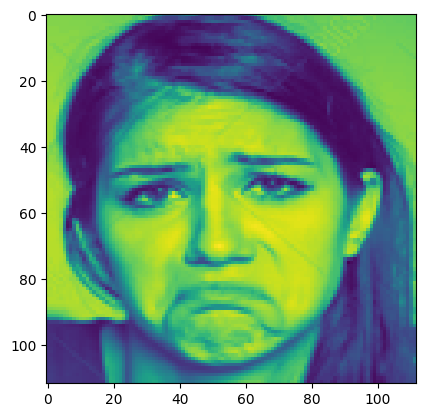

In [ ]:
test1 = prep('/content/test2.png')
print(classify(test1))

In [ ]:
from keras.models import load_model

In [ ]:
model = load_model('/content/model.keras')

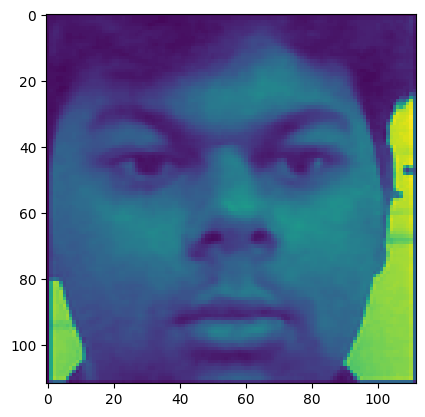

In [ ]:
check = prep('/content/opencv_face_0.png')


In [ ]:
print(classify(check))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
Neutral


In [1]:
!pip show tensorflow

Name: tensorflow
Version: 2.17.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tf_keras


In [2]:
!pip show keras


Name: keras
Version: 3.4.1
Summary: Multi-backend Keras.
Home-page: https://github.com/keras-team/keras
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache License 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, h5py, ml-dtypes, namex, numpy, optree, packaging, rich
Required-by: tensorflow
